In [1]:
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from lightgbm import LGBMClassifier, log_evaluation, early_stopping


rc = {
    "axes.facecolor": "#2E3440",
    "figure.facecolor": "#2E3440",
    "axes.edgecolor": "#4C566A",
    "grid.color": "#4C566A",
    "font.family": "JetBrains Mono",
    "text.color": "#FFFFFF",
    "axes.labelcolor": "#FFFFFF",
    "xtick.color": "#FFFFFF",
    "ytick.color": "#FFFFFF",
    "grid.alpha": 0.4,
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "legend.title_fontsize": 10
}

bp_props = {
    'boxprops':{'facecolor':'#037d97', 'edgecolor':'white'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'white'},
    'capprops':{'color':'white'},
    'flierprops':{'marker':'x', 'markeredgecolor':'white'}
}

sns.set(rc=rc)

In [2]:
train_df = pd.read_csv('train.csv', index_col='id')
test_df = pd.read_csv('test.csv', index_col='id')

# orig_df = pd.read_csv('original.csv')

for df in [train_df, test_df]:
    df.rename(columns={'height(cm)': 'height', 
                       'weight(kg)': 'weight', 
                       'waist(cm)': 'waist', 
                       'eyesight(left)': 'eyesight_left',
                       'eyesight(right)': 'eyesight_right', 
                       'hearing(left)': 'hearing_left', 
                       'hearing(right)': 'hearing_right',
                       'fasting blood sugar': 'fbs',
                       'Cholesterol': 'cholesterol',
                       'Urine protein': 'up',
                       'serum creatinine': 'sc',
                       'dental caries': 'dc'}, inplace=True)

target_var = 'smoking'
cat_features = ['hearing_left', 'hearing_right', 'up', 'dc', ]
num_features = ['age', 'height', 'weight', 'waist', 'eyesight_left', 'eyesight_right', 'systolic', 'relaxation', 'fbs', 'cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'sc', 'AST', 'ALT', 'Gtp',]

# Data Description

In [3]:
train_df.head()

,age,height,weight,waist,eyesight_left,eyesight_right,hearing_left,hearing_right,systolic,relaxation,...,HDL,LDL,hemoglobin,up,sc,AST,ALT,Gtp,dc,smoking
id,,,,,,,,,,,,,,,,,,,,,
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,57,126,16.2,1,1.1,27,23,37,1,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,45,93,17.4,1,0.8,27,31,53,0,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,38,102,15.9,1,1.0,20,27,30,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,44,93,15.4,1,0.8,19,13,17,0,1


## Shape and Columns

In [4]:
print('Train Descriptors')
print(f'Shape: {train_df.shape}')
print(f'Columns : {train_df.columns}')
print('')
print('Test Descriptors')
print(f'Shape: {test_df.shape}')
print(test_df.columns)

Train Descriptors
Shape: (159256, 23)
Columns : Index(['age', 'height', 'weight', 'waist', 'eyesight_left', 'eyesight_right',
       'hearing_left', 'hearing_right', 'systolic', 'relaxation', 'fbs',
       'cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'up', 'sc',
       'AST', 'ALT', 'Gtp', 'dc', 'smoking'],
      dtype='object')

Test Descriptors
Shape: (106171, 22)
Index(['age', 'height', 'weight', 'waist', 'eyesight_left', 'eyesight_right',
       'hearing_left', 'hearing_right', 'systolic', 'relaxation', 'fbs',
       'cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'up', 'sc',
       'AST', 'ALT', 'Gtp', 'dc'],
      dtype='object')


## Missing Values

In [5]:
null_values = {'column': [], 'train_null_values': [], 'test_null_values': []}

for col in test_df.columns:
    train_col_null = train_df[col].isna().sum()
    test_col_null = test_df[col].isna().sum()
    
    null_values['column'].append(col)
    null_values['train_null_values'].append(train_col_null)
    null_values['test_null_values'].append(test_col_null)
    
null_values = pd.DataFrame(null_values)
null_values['train_total'] = train_df.shape[0]
null_values['test_total'] = test_df.shape[0]
null_values['train_null_perc'] = null_values['train_null_values'] / null_values['train_total']
null_values['test_null_perc'] = null_values['test_null_values'] / null_values['test_total']
null_values.sort_values(by='train_null_perc', inplace=True, ascending=False)

null_values.style.format({'train_null_perc': '{:.0%}',
                          'test_null_perc': '{:.0%}'})

,column,train_null_values,test_null_values,train_total,test_total,train_null_perc,test_null_perc
0,age,0,0,159256,106171,0%,0%
1,height,0,0,159256,106171,0%,0%
20,Gtp,0,0,159256,106171,0%,0%
19,ALT,0,0,159256,106171,0%,0%
18,AST,0,0,159256,106171,0%,0%
17,sc,0,0,159256,106171,0%,0%
16,up,0,0,159256,106171,0%,0%
15,hemoglobin,0,0,159256,106171,0%,0%
14,LDL,0,0,159256,106171,0%,0%
13,HDL,0,0,159256,106171,0%,0%


In [6]:
null_values_per_row = train_df.isna().sum(axis=1)
pd.DataFrame(null_values_per_row.value_counts().sort_index())

,count
0,159256


In [7]:
missing_values = {'column': [], 'only_in_train': [], 'only_in_test': []}

for col in cat_features:
    train_col_unique = train_df[col].unique()
    test_col_unique = test_df[col].unique()
    
    missing_values['column'].append(col)
    missing_values['only_in_train'].append([f for f in train_col_unique if f not in test_col_unique])
    missing_values['only_in_test'].append([f for f in test_col_unique if f not in train_col_unique])

missing_values = pd.DataFrame(missing_values)
missing_values

,column,only_in_train,only_in_test
0,hearing_left,[],[]
1,hearing_right,[],[]
2,up,[],[]
3,dc,[],[]


## Adversarial Testing

### Train vs Test

In [8]:
df = pd.concat([train_df[num_features].assign(source=0), test_df[num_features].assign(source=1)], ignore_index=True)
origin_var = df['source']
df.drop(columns='source', inplace=True)

n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((df.shape[0],))
train_oof_probas = np.zeros((df.shape[0],))

for fold, (train_index, test_index) in enumerate(k_fold.split(df, origin_var)):
    print('-----> Fold {} <-----'.format(fold+1))
    X_train, X_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
    y_train, y_valid = origin_var.iloc[train_index], origin_var.iloc[test_index]
    
    model = LGBMClassifier(
        random_state=2023,
        objective='binary',
        metric='auc',
        n_jobs=-1,
        n_estimators=2000,
        verbose=-1,
        max_depth=3,
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(2000),
        ]
    )
    
    oof_preds = model.predict(X_valid)
    oof_probas = model.predict_proba(X_valid)[:,1]
    train_oof_preds[test_index] = oof_preds
    train_oof_probas[test_index] = oof_probas
    print(': AUC ROC = {}'.format(roc_auc_score(y_valid, oof_probas)))

auc_vanilla = roc_auc_score(origin_var, train_oof_probas)
fpr, tpr, _ = roc_curve(origin_var, train_oof_probas)
print("--> Overall results for out of fold predictions")
print(": AUC ROC = {}".format(auc_vanilla))

-----> Fold 1 <-----
: AUC ROC = 0.5018371905443353
-----> Fold 2 <-----
: AUC ROC = 0.503032969230766
-----> Fold 3 <-----
: AUC ROC = 0.5019569689012746
-----> Fold 4 <-----
: AUC ROC = 0.5033639018608528
-----> Fold 5 <-----
: AUC ROC = 0.5023024726730336
--> Overall results for out of fold predictions
: AUC ROC = 0.5018332923128576


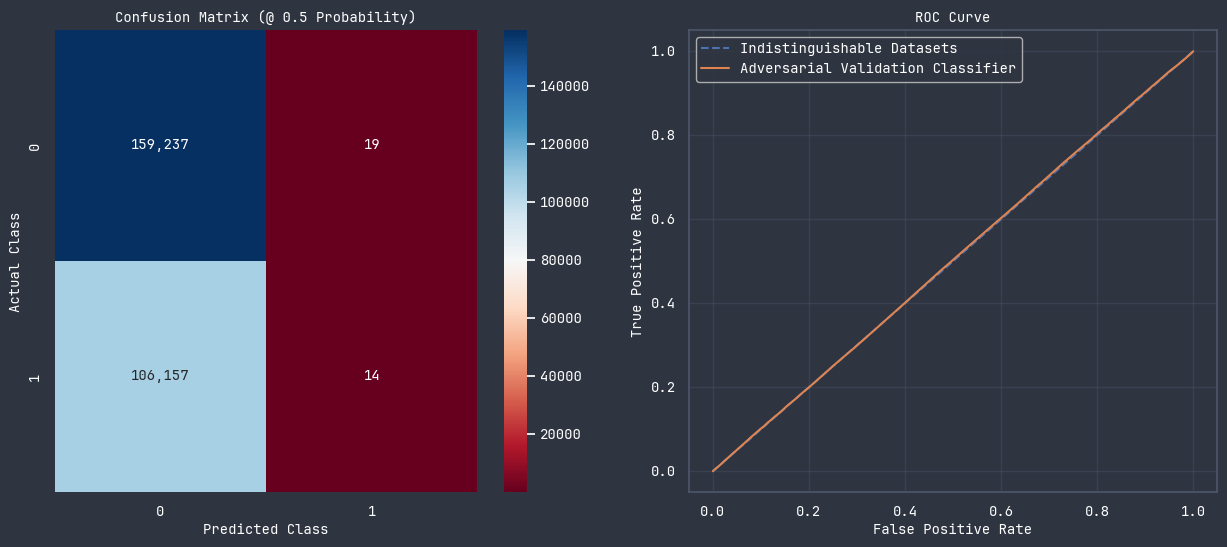

In [9]:
confusion = confusion_matrix(origin_var, train_oof_preds)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

sns.heatmap(confusion, annot=True, fmt=",d", cmap='RdBu', ax=axs[0])
axs[0].set_title("Confusion Matrix (@ 0.5 Probability)")
axs[0].set_ylabel("Actual Class")
axs[0].set_xlabel("Predicted Class")

sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets", ax=axs[1])
sns.lineplot(x=fpr, y=tpr, ax=axs[1], label="Adversarial Validation Classifier")
axs[1].set_title("ROC Curve")
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")

plt.show()

### Train/Test Original

In [ ]:
df = pd.concat([train_df[num_features].assign(source=0), test_df[num_features].assign(source=0), orig_df[num_features].assign(source=1)], ignore_index=True)
origin_var = df['source']
df.drop(columns='source', inplace=True)

n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((df.shape[0],))
train_oof_probas = np.zeros((df.shape[0],))

for fold, (train_index, test_index) in enumerate(k_fold.split(df, origin_var)):
    print('-----> Fold {} <-----'.format(fold+1))
    X_train, X_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
    y_train, y_valid = origin_var.iloc[train_index], origin_var.iloc[test_index]
    
    model = LGBMClassifier(
        random_state=2023,
        objective='binary',
        metric='auc',
        n_jobs=-1,
        n_estimators=2000,
        verbose=-1,
        max_depth=3,
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(2000),
        ]
    )
    
    oof_preds = model.predict(X_valid)
    oof_probas = model.predict_proba(X_valid)[:,1]
    train_oof_preds[test_index] = oof_preds
    train_oof_probas[test_index] = oof_probas
    print(': AUC ROC = {}'.format(roc_auc_score(y_valid, oof_probas)))

auc_vanilla = roc_auc_score(origin_var, train_oof_probas)
fpr, tpr, _ = roc_curve(origin_var, train_oof_probas)
print("--> Overall results for out of fold predictions")
print(": AUC ROC = {}".format(auc_vanilla))

In [ ]:
confusion = confusion_matrix(origin_var, train_oof_preds)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

sns.heatmap(confusion, annot=True, fmt=",d", cmap='RdBu', ax=axs[0])
axs[0].set_title("Confusion Matrix (@ 0.5 Probability)")
axs[0].set_ylabel("Actual Class")
axs[0].set_xlabel("Predicted Class")

sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets", ax=axs[1])
sns.lineplot(x=fpr, y=tpr, ax=axs[1], label="Adversarial Validation Classifier")
axs[1].set_title("ROC Curve")
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")

plt.show()

# Exploratory Data Analysis

## Variable Distribution

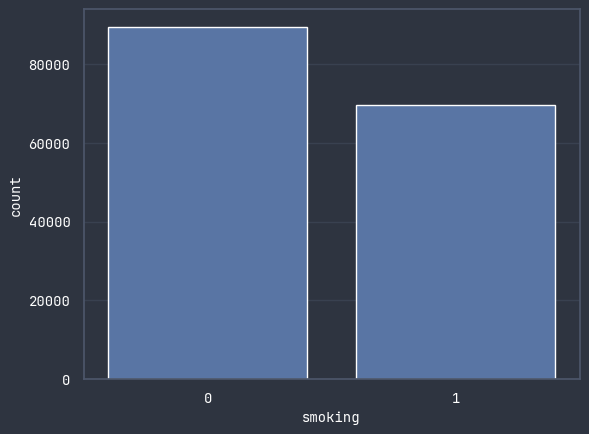

In [49]:
sns.countplot(data=train_df, x=target_var)
plt.show()

## Variable Correlation

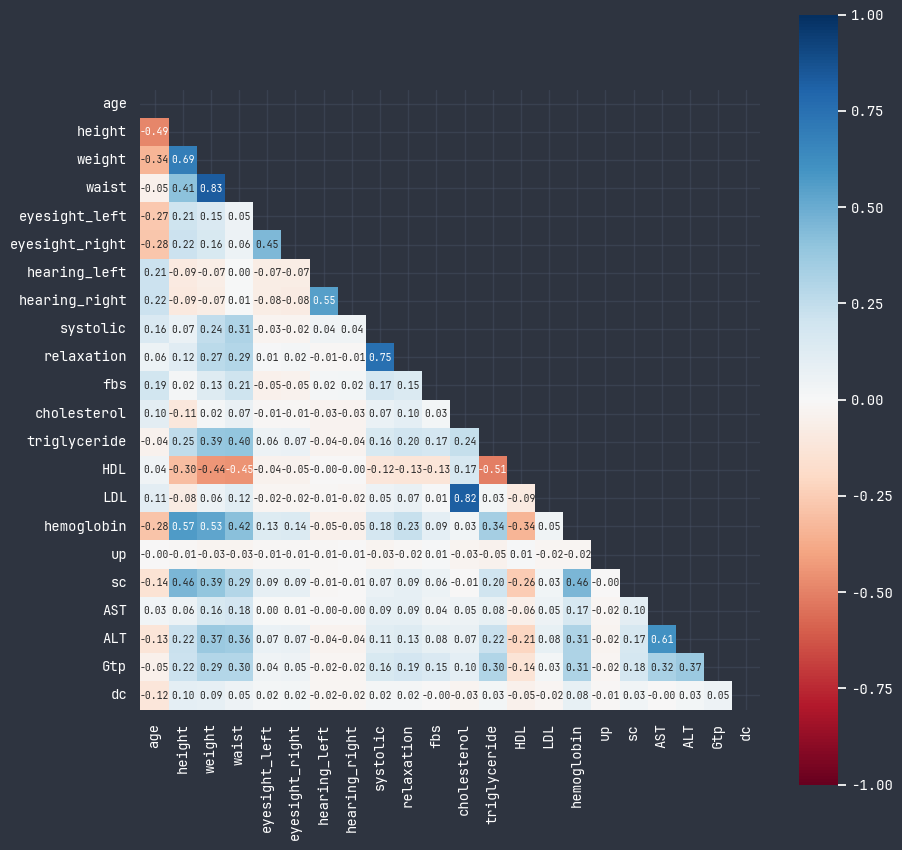

In [51]:
df = pd.concat([train_df[test_df.columns], test_df], ignore_index=True)
df_corr = df.corr(method='pearson')
mask = np.triu(np.ones_like(df_corr, dtype=bool))

plt.figure(figsize=(10, 10))
sns.heatmap(df_corr, mask=mask, annot=True, annot_kws={"size": 7}, fmt='.2f', cmap='RdBu', square=True, vmin=-1, vmax=1)
plt.show()

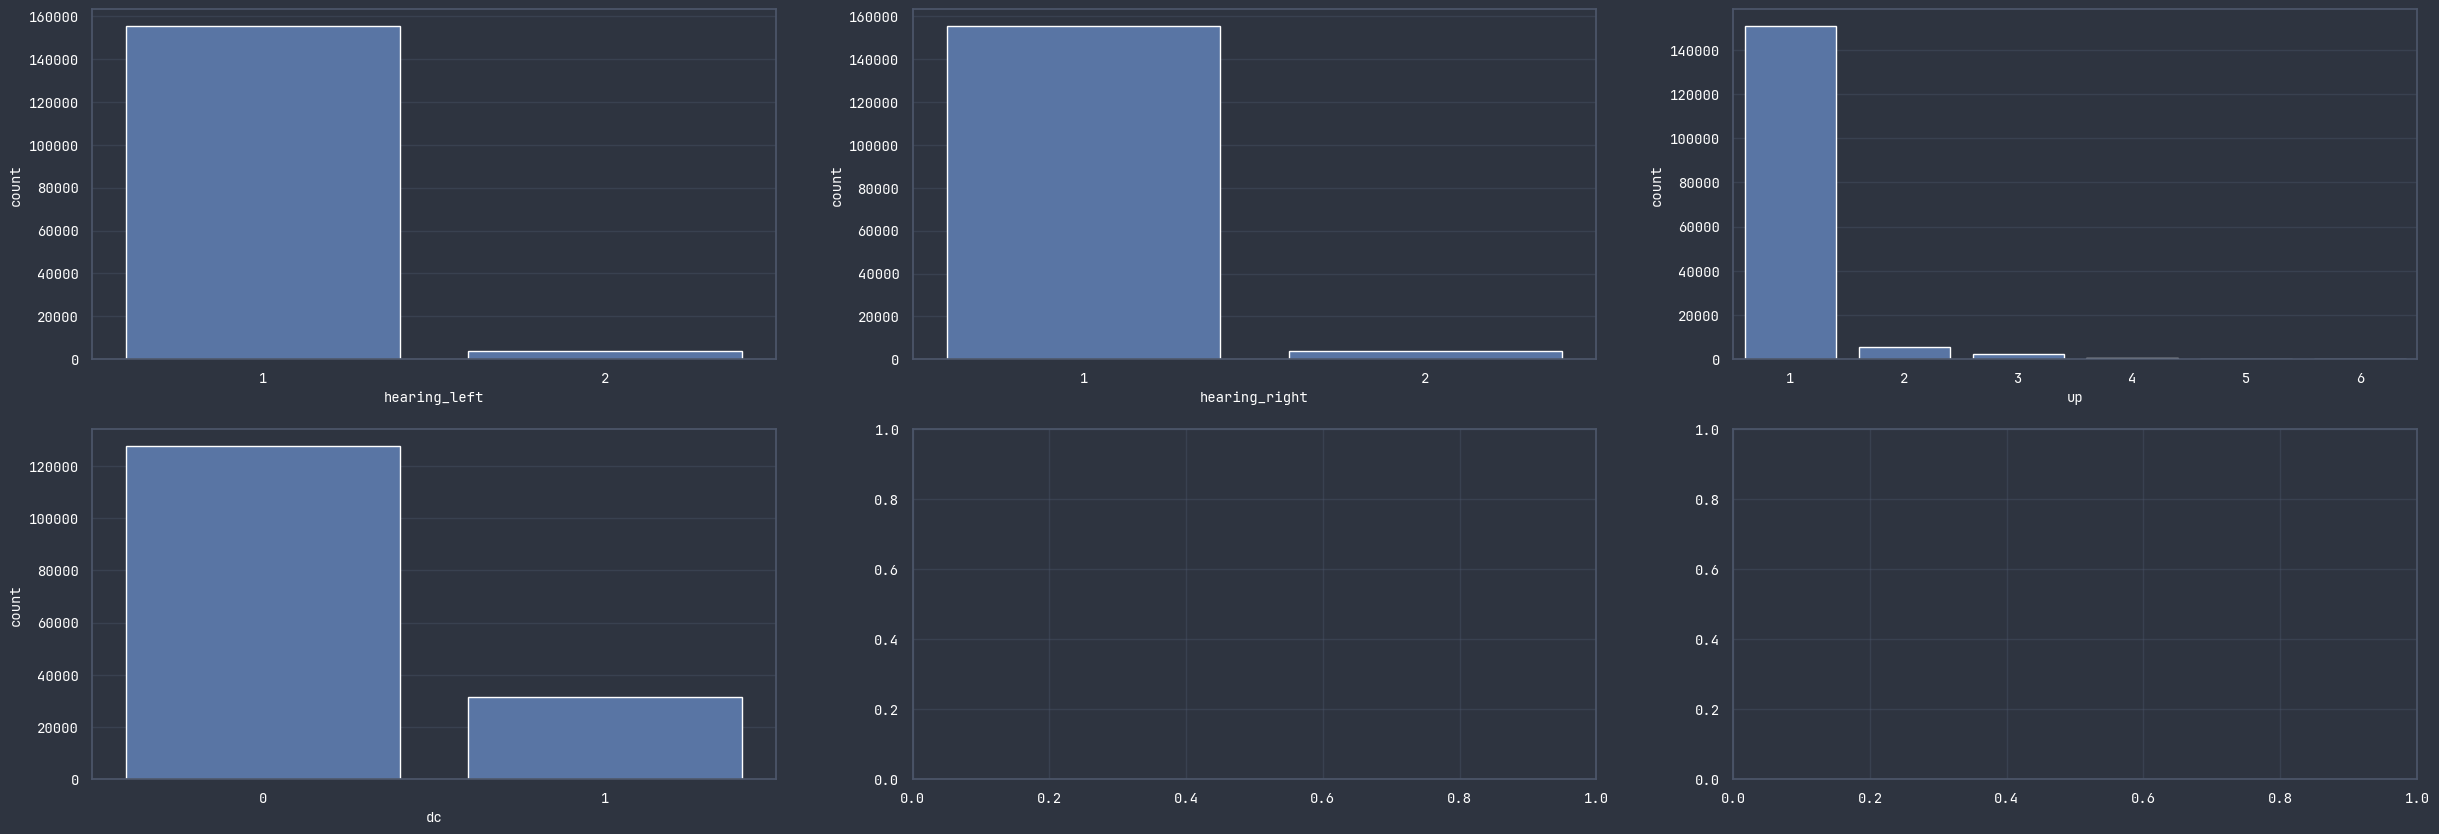

In [55]:
fig, axs = plt.subplots(nrows=len(cat_features)//3 + 1, ncols=3, figsize=(30, 5 * (len(cat_features)//3 + 1)))
axs = axs.flatten()

for i, feat in enumerate(cat_features):
    sns.countplot(data=train_df, x=feat, ax=axs[i])
plt.show()

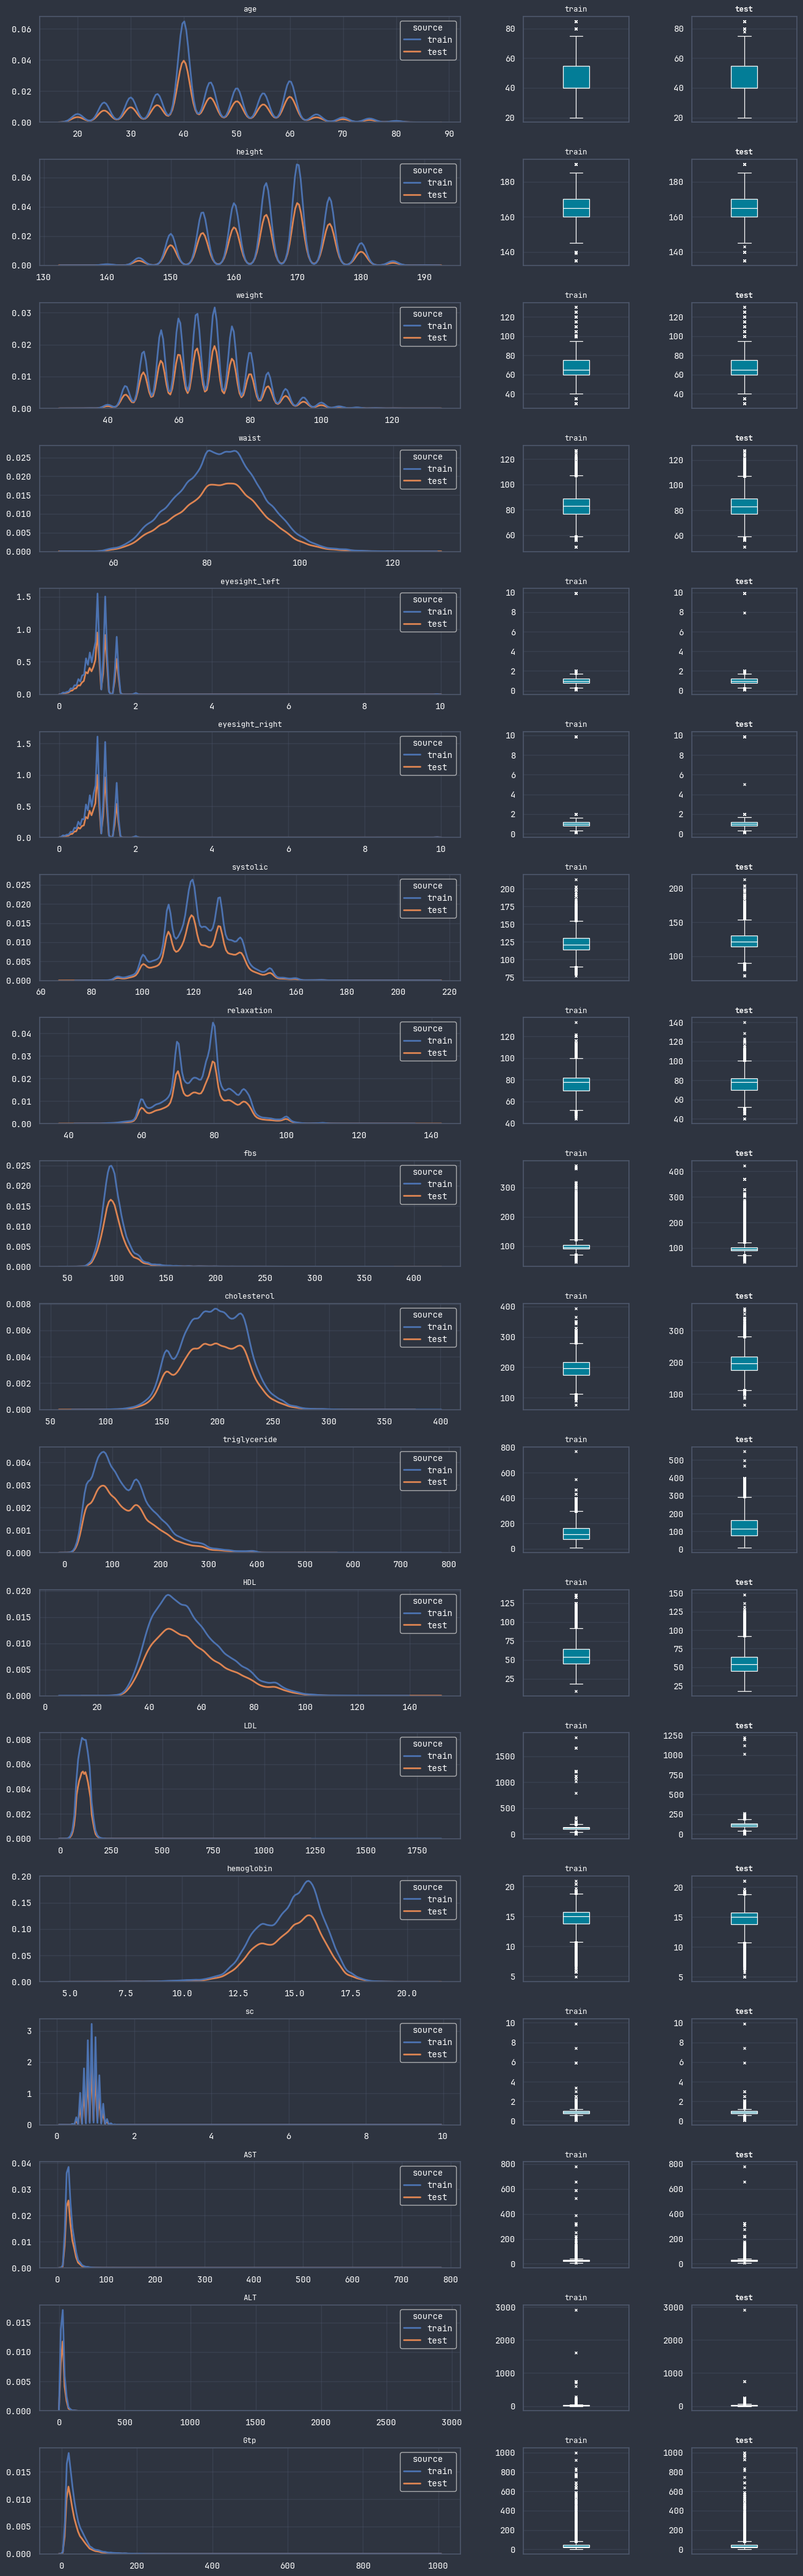

In [77]:
df = pd.concat([train_df[num_features].assign(source='train'), test_df[num_features].assign(source='test')], ignore_index=True)

fig, axs = plt.subplots(nrows=len(num_features), ncols=3, figsize=(16, len(num_features) * 3),
                        gridspec_kw= {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.8, 0.2, 0.2]})

for i, feat in enumerate(num_features):
    sns.kdeplot(data=df[[feat, 'source']], x=feat, hue='source', linewidth=2, ax=axs[i, 0])
    axs[i, 0].set_title(feat, fontsize=9)
    axs[i, 0].set(xlabel='', ylabel='')
    
    sns.boxplot(data=df.loc[df['source'] == 'train', [feat]], y=feat, width=0.25, saturation=0.9, linewidth=0.9, fliersize=2.25, ax=axs[i, 1], **bp_props)
    axs[i, 1].set_title('train', fontsize=9)
    axs[i, 1].set(xlabel='', ylabel='')
    
    sns.boxplot(data=df.loc[df['source'] == 'test', [feat]], y=feat, width=0.25, saturation=0.9, linewidth=0.9, fliersize=2.25, color='#037d97', ax=axs[i, 2], **bp_props)
    axs[i, 2].set_title('test', fontsize=9, fontweight='bold')
    axs[i, 2].set(xlabel='', ylabel='')

plt.tight_layout()
plt.show()